In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit
from networkx.algorithms import community
import pandas as pd
import random

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

In [2]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return lines

def find_index(lst):
    return int(lst[-2])

def find_name(lst):
    return lst[-1]

def find_edges(lst):
    # Split each string in the list by whitespace, convert to integers, and store in a new list
    processed_lst = [list(map(int, item.strip().split())) for item in lst]
    return np.array(processed_lst)

yeast = read_file('LAB3-data/YeastS.net') # list of strings, 2361 vertices
yeast = yeast[12:]
N_vertices = 2361 

vertices = np.array([find_index(yeast[i].split(" ")) for i in range(N_vertices)]) # equivalent to np.arange(1, 2361+1)
names = [find_name(yeast[i].split(" ")) for i in range(N_vertices)] 
names = [name[1:-2] for i, name in enumerate(names)] # Names of the vertices ['YBR236C', 'YOR151C', 'YML010W', ...]

edges = find_edges(yeast[N_vertices+1:]) - 1 # egdes of the graph, subtracting 1 so the indices starts with 0
N_edges = len(edges)

# Visualizing the graph

For visualization porpurses, I will only look at the first N cases. For N = 200, there seems to be around 11 clusters if we ignore the single separated vertex.

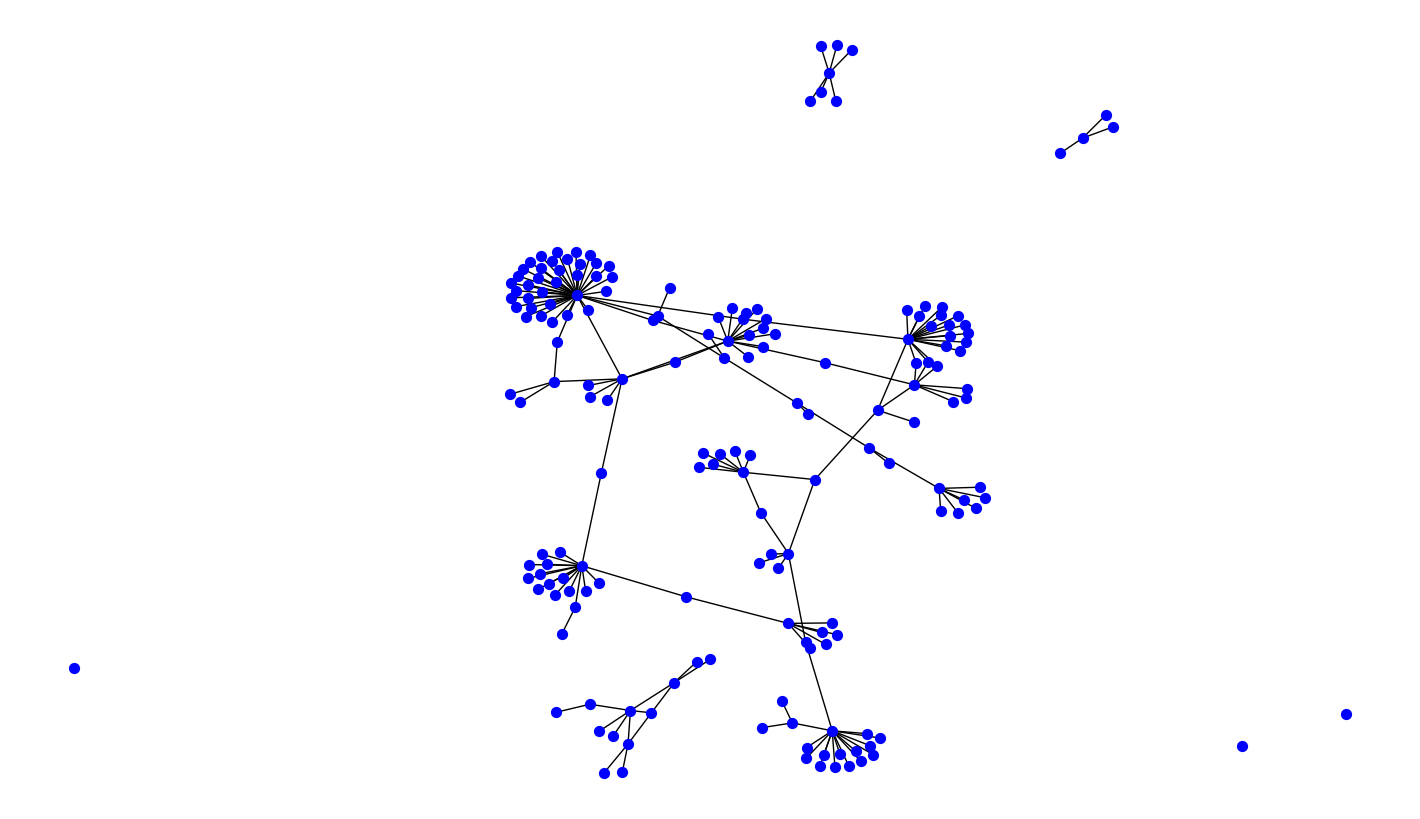

In [3]:
N = 200
edges_subset = edges[:N]
names_subset = names[:N]

G = nx.Graph()
for edge in edges_subset:
    G.add_edge(edge[0], edge[1])

unique_nodes = np.unique(edges_subset)
name_mapping = dict(zip(unique_nodes, names[:len(unique_nodes)]))

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=50, node_color="blue", font_weight='bold')
# nx.draw_networkx_labels(G, pos, labels=name_mapping, font_size=8) # optional labels of the vertices (messy if N > 100)
plt.show()

# Computing the modularity of the subgraph (N=200)
I used the Girvan-Newman algorithm for determining the set of all possible ways the graph can be partitioned.
The algorithm works by iterating through each possible partiotion, then for each partition it computes the corresponding modularity.
After looping through all the partition configurations, the algorithm finds the the partition that have the largest modularity and returns a list of sets of cluster indices i.e. [cluster_1, cluster_2, ..., cluster_n]. 
Note that this is a brute force algorithm that only works on smaller graphs.

In [4]:
def compute_modularity(G, clusters):
    total_edges = 2 * G.number_of_edges() # times 2 to get an undirected graph (the original graph is a directed graph)
    modularity = 0

    # Iterate over each cluster
    for cluster in clusters:
        # Calculate e_ii and a_i for the current cluster
        volume = 0 # sum of degrees of the cluster
        e = 0 # edges in a cluster
        
        for node_i in cluster:
            for node_j in cluster:
                if G.has_edge(node_i, node_j):
                    e += 1 if node_i != node_j else 0 # asssuming the vertices have no self loop

        # Calculate a_i separately
        for node in cluster:
            volume += G.degree(node)
        
        # Update modularity
        modularity += e / total_edges - volume**2 / (4 * total_edges**2)

    return modularity


# The Girvan-Newman algorithm returns an iterator of sets of nodes in each cluster
girvan_newman_clusters = community.girvan_newman(G)

def find_best_girvan_newman_clustering(G, clusters_iter):
    best_clusters = []
    # Setting it to zero by assuming that the graph is initialized to be random.
    best_modularity = 0 

    for clusters in clusters_iter:
        modularity_value = compute_modularity(G, clusters) # Computing Q
        # When a better modularity (Q) is found, then it will get replaced by the higher value of Q.
        if modularity_value >= best_modularity:
            best_modularity = modularity_value # Replaces the previously smallest Q
            best_clusters = clusters # Accepts a cluster if the Q increases

    return best_clusters, best_modularity

best_clusters, best_modularity = find_best_girvan_newman_clustering(G, girvan_newman_clusters)
num_clusters = len(best_clusters)

print("Number of clusters:", num_clusters)
print("Modularity:", best_modularity)

Number of clusters: 11
Modularity: 0.83455625


The modularity is close to 1 which indicates that it is "obvious" that there are clusters in the graph. 

# Generating a random graph
This is done by the function generate\_er\_graph which randomly assigns a pair of 1 in a n by n matrix. 
The result is an adjacency matrix (without cossidering any self loop) that have randomly assigned edges where the probability is defined by $p$.

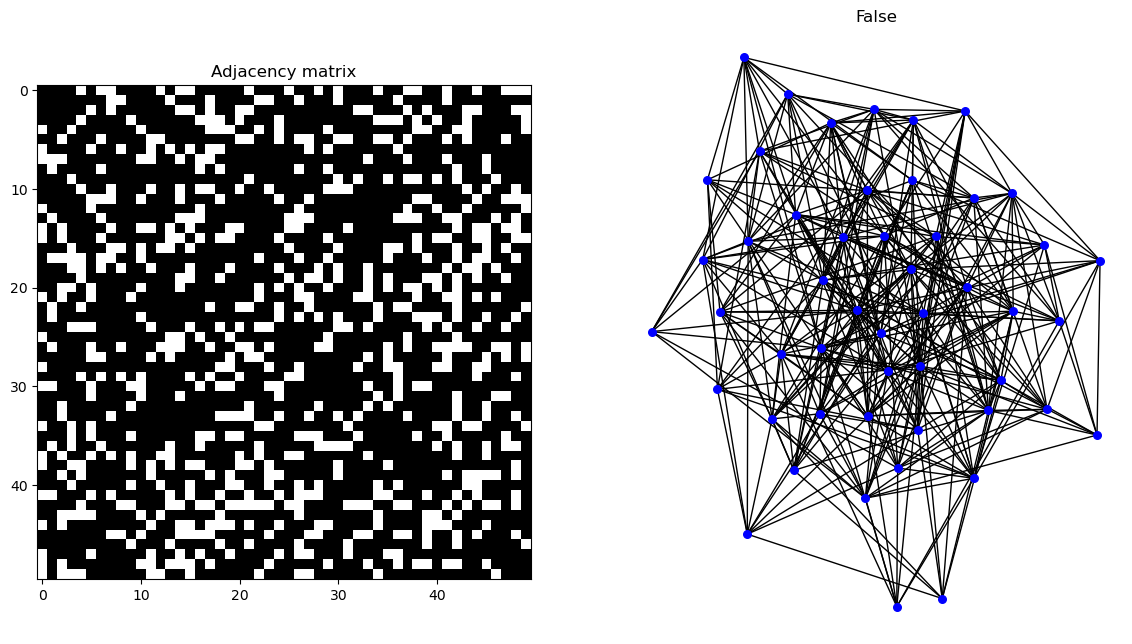

In [5]:
@njit
def generate_er_graph(n, p):
    A = np.zeros((n, n), dtype=np.int32)
    
    for i in range(n):
        for j in range(i + 1, n): # skipping the main diagonal
            r = random.random()
            if r < p:
                A[i, j] = 1
                A[j, i] = 1                    
    return A

@njit
def check_connectivity(A): # True if disconnected, False if connected
    row_edge_degrees = A.sum(0)
    connectivity = np.sum(row_edge_degrees == 0.0) 

    if connectivity > 0: 
        return True
    else:
        return False


n = 50 # number fo vertices
p = 0.3 # probability

adj_matrix = generate_er_graph(n, p)
fig, ax = plt.subplots(1,2)

ax[0].set_title("Adjacency matrix")
ax[0].imshow(adj_matrix)
G = nx.from_numpy_array(adj_matrix)
ax[1].set_title(f"{check_connectivity(adj_matrix)}")
nx.draw(G, node_color='blue', font_weight='bold', ax=ax[1], node_size=30)

## Verifying that the graph is almost surely disconnected for $p < \frac{\ln n}{n}$
The adjacency matrix is symmetric for an undirected graph. If it is disconnected, then there exist a vertex that have edge degree zero. 
Conversely, if there is no row that sums to zero, then the graph that correspond to the adjacency matrix is connected.
The implementation is the check\_connectivity function defined in the previous code block.

In [6]:
result = []
n = 10000 # Number of vertices
p = 0.5 * np.log(n) / n # the 0.9 factor makes the probability below the critical threshold
print("threshold probability:", np.log(n) / n)
print(f"{p = :.6f}")

# Creating a large number of independent ER-random graphs with the same probability and checking whether if they are connected
for _ in tqdm(range(1000)):
    adj_matrix = generate_er_graph(n, p)
    is_disconnected = check_connectivity(adj_matrix)
    result.append(is_disconnected) # True if disconnected, False if connected

threshold probability: 0.0009210340371976184
p = 0.000461


100%|██████████| 1000/1000 [1:45:40<00:00,  6.34s/it]   


In [7]:
print(f"Number of connected graphs {len(result) - np.sum(result)}")
print(f"Number of disconnected graphs {np.sum(result)}")

Number of connected graphs 0
Number of disconnected graphs 1000


## Verifying that the graph is almost surely connected for $p > \frac{\ln n}{n}$

In [8]:
result = []
n = 10000 # Number of vertices
p = 2 * np.log(n) / n
print("threshold probability:", np.log(n) / n)
print(f"{p = :.6f}")

# Creating a large number of independent ER-random graphs with the same probability and checking whether if they are connected
for _ in tqdm(range(1000)):
    adj_matrix = generate_er_graph(n, p)
    is_connected = check_connectivity(adj_matrix)
    result.append(is_connected) # True if disconnected, False if connected

threshold probability: 0.0009210340371976184
p = 0.001842


100%|██████████| 1000/1000 [09:34<00:00,  1.74it/s]


In [9]:
print(f"Number of connected graphs {len(result) - np.sum(result)}")
print(f"Number of disconnected graphs {np.sum(result)}")

Number of connected graphs 1000
Number of disconnected graphs 0


## A more quantitative analysis
Let's plot how the fraction of graphs that is connected and fraction of disconnected for several different values of $p$

In [10]:
connected_frac = []
disconnected_frac = []

n = 10000 # Number of vertices

log_distributed_factors = np.log( np.linspace(np.e**0.95, np.e**1.1, 20) ) # uniform log distributed numbers from 0.9 to 1.1
probabilities = 1.0 * log_distributed_factors * np.log(n) / n 

for p in tqdm(probabilities):
    result = []
    for _ in range(1000):
        adj_matrix = generate_er_graph(n, p)
        is_connected = check_connectivity(adj_matrix)
        result.append(is_connected) # True if disconnected, False if connected
        
    # connected / total
    connected_frac.append(
        (len(result) - np.sum(result)) / len(result)
    )
    
    # disconnected / total
    disconnected_frac.append(
        np.sum(result) / len(result)
    )

100%|██████████| 20/20 [4:58:59<00:00, 896.99s/it]   


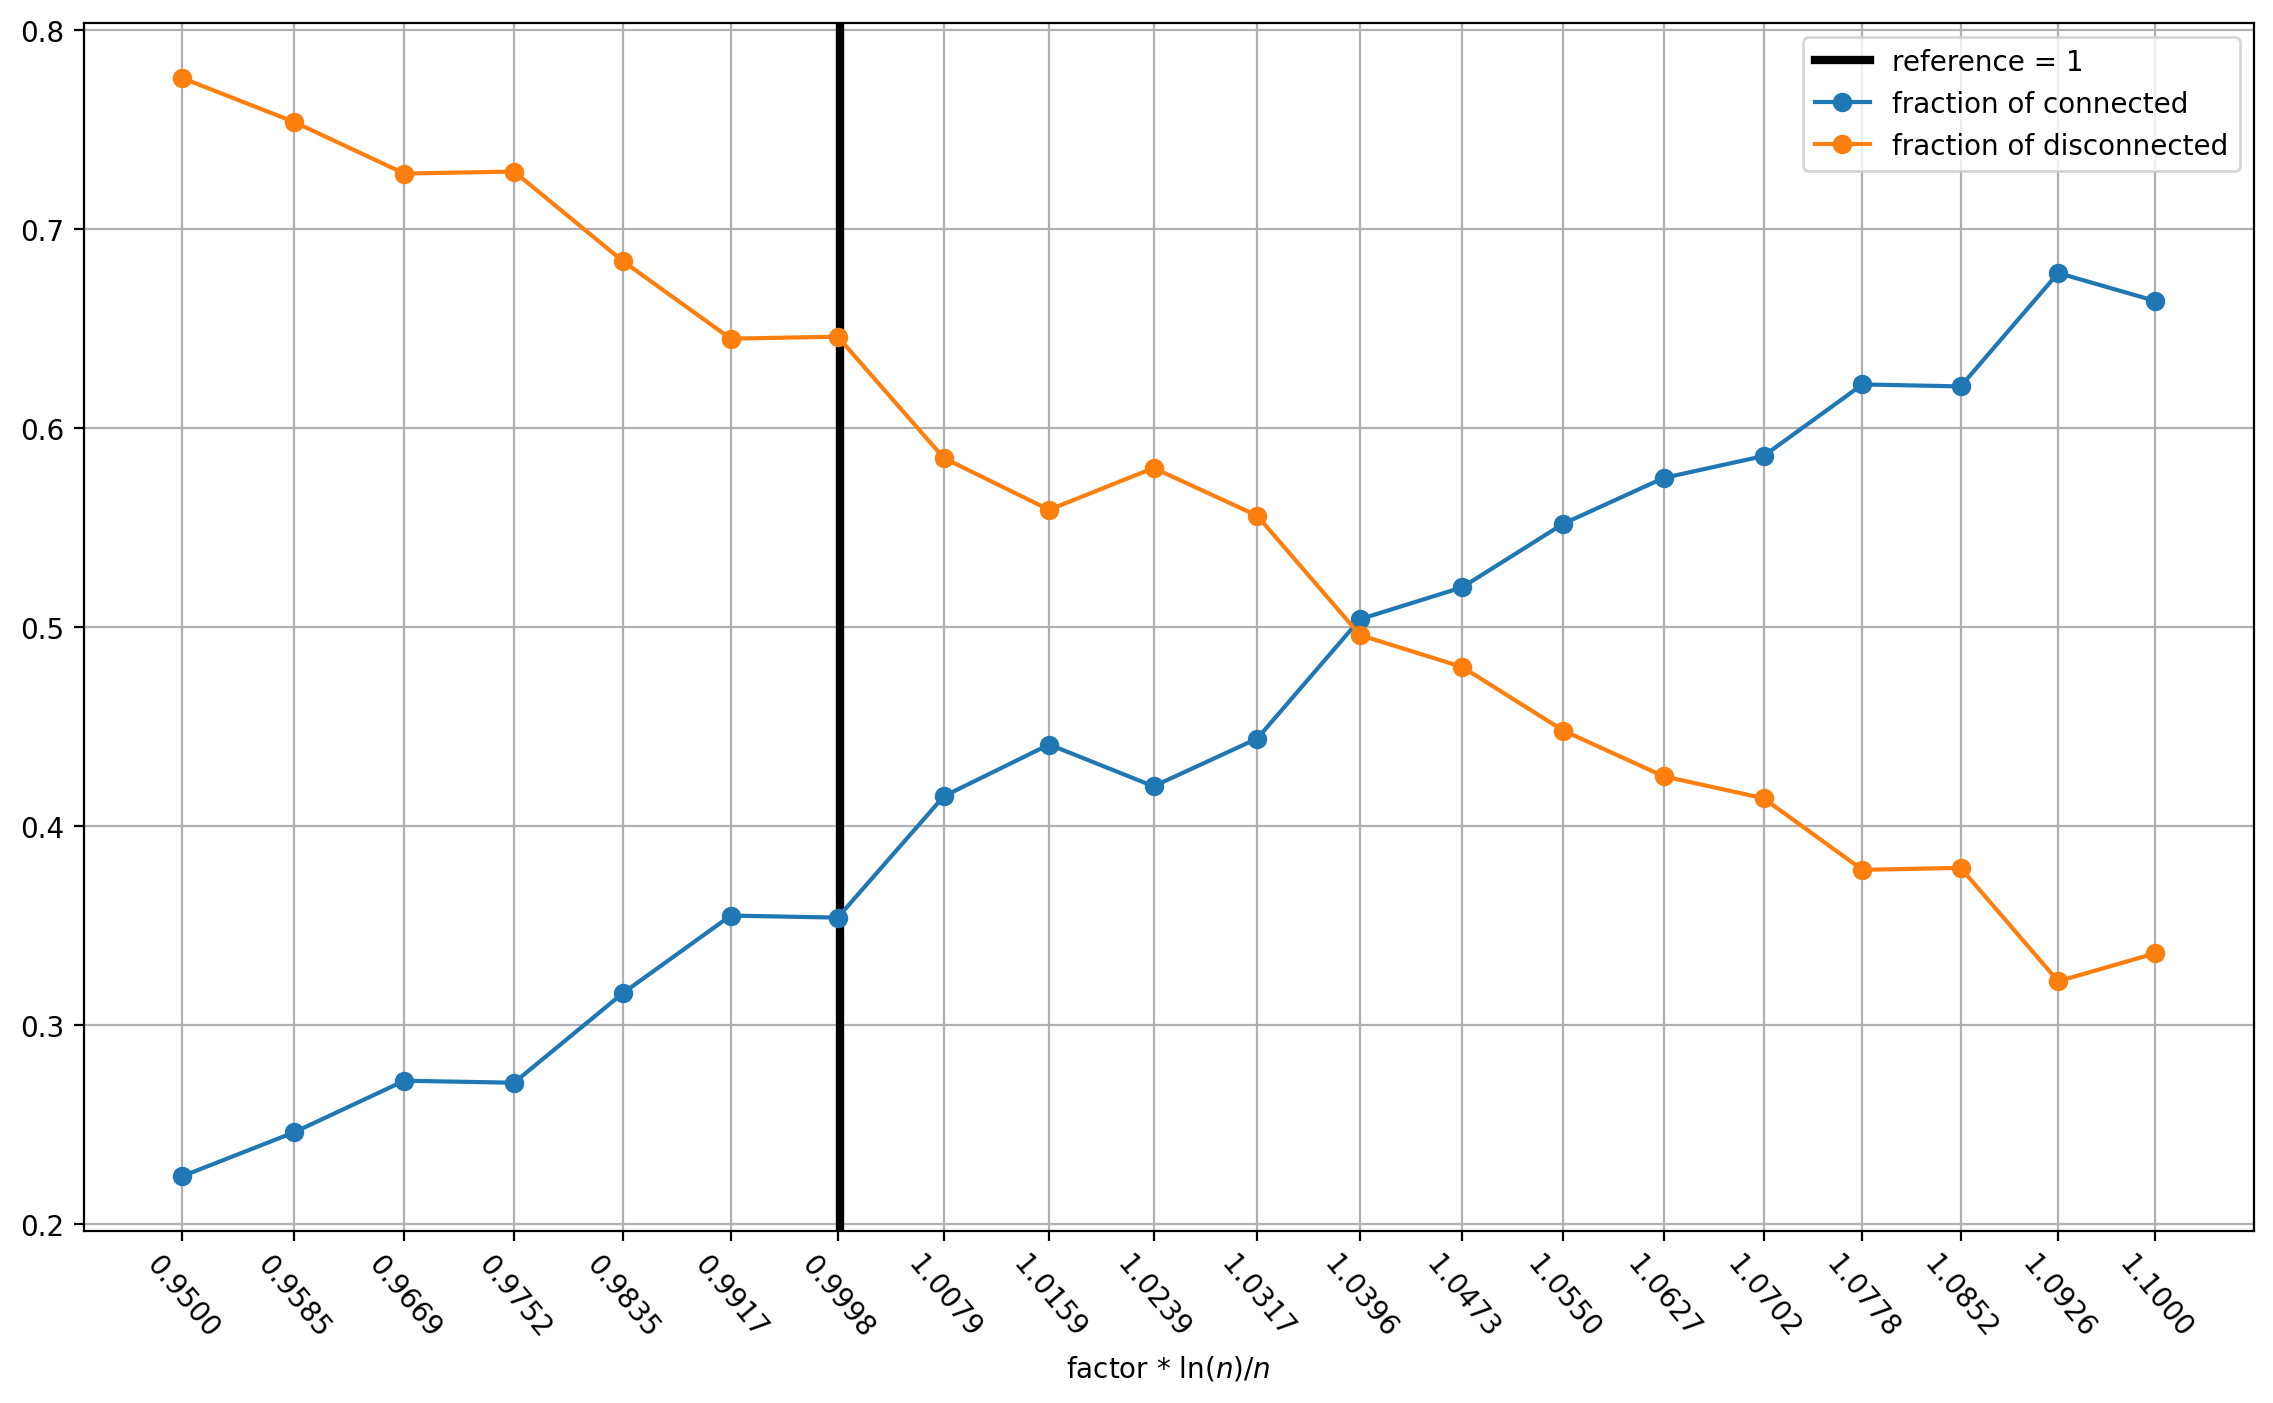

In [11]:
plt.figure(dpi=200)

plt.axvline(1, label="reference = 1", lw=3, color="black")
plt.plot(log_distributed_factors, connected_frac, "o-", label="fraction of connected")
plt.plot(log_distributed_factors, disconnected_frac, "o-", label="fraction of disconnected")

plt.xlabel("factor * $\ln(n)/n$")
plt.xticks(log_distributed_factors, rotation=310)
plt.legend()
plt.grid()
plt.show()

# Computing the global clustering coefficient
The global clustering coefficient $C$ is given by 
$$C = \frac{3c_3}{p_2}$$ where
$$c_3 = \frac{1}{6}\mathrm{Tr}(A)^3$$
$$p_2 = \frac{1}{2}\sum_{i,j}\left[ A^2 - \mathrm{diag}(A^2)\right] $$

In [12]:
@njit
def global_clustering_coefficient(A): # Function for computing the global clustering coefficient given some adjacency matrix A
    # Compute A^2 and A^3
    A_sq = A @ A
    A_cube = A_sq @ A

    # Calculate the number of triangles (c3)
    trace_A_cube = np.trace(A_cube)
    num_triangles = trace_A_cube / 6 

    # Calculate the number of paths of length 2 (p2)
    num_paths_length_2 = 0.5 * (np.sum(A_sq) - np.trace(A_sq)) 

    # Compute the global clustering coefficient (C)
    C = (3 * num_triangles) / num_paths_length_2

    return C

residuals = []
average_C = []
probabilities = np.linspace(0.1, 1, 10)
vertices = [50, 100, 200, 400, 800] 

for n in vertices: # checking the O(1/sqrt(n)) hypothesis
    results = []
    for p in tqdm(probabilities):
        result = []
        for _ in range(1000):

            adj_matrix = generate_er_graph(n, p).astype(np.float64)
            C = global_clustering_coefficient(adj_matrix)

            result.append(C) # [C_1, C_2, ..., C_n]
        
        # Average C for a given p
        results.append(
            np.sum(result) / len(result)
        )
    
    # Average clobal clustering coefficient for some given n
    average_C.append(results) 
    # Storing the residuals between C and p for some given n to check the O(1/sqrt(n)) hypothesis
    residuals.append(np.array(results) - probabilities) 

residuals = np.array(residuals)
average_C = np.array(average_C)

residuals.shape, average_C.shape

100%|██████████| 10/10 [10:05<00:00, 60.59s/it]


((5, 10), (5, 10))

We can see in the figure below that there is clearly a linear relationship between the probability and the global clustering coefficient.

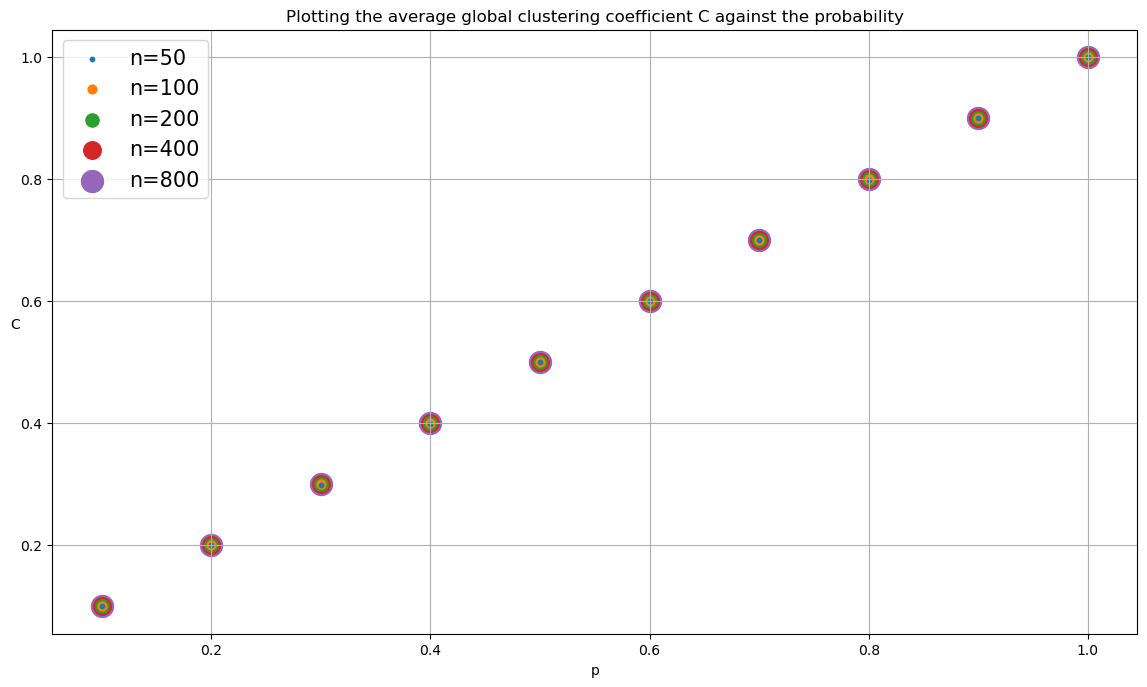

In [13]:
plt.title("Plotting the average global clustering coefficient C against the probability")

for i in range(len(average_C)):
    plt.scatter(probabilities, average_C[i], s=10*(i+1)**2, label=f"n={vertices[i]}", zorder=-i)
    
plt.xlabel("p"), plt.ylabel("C", rotation=0)
plt.legend(fontsize=15)
plt.grid()

## Verifying that error decreases like $O\left(1 / \sqrt{n}\right)$
To do this, I define the error to be the root mean squared error (RMSE). The $n$ is doubling for evey iteration. What we would expect is that the RMSE will decrease with a factor $1/\sqrt{2}$ when the number fo vertices doubles. 

In [14]:
RMSE = np.sqrt(np.mean(residuals**2, 1))

RMSE[:-1] / RMSE[1:]

array([4.20675997, 2.79110307, 1.4481219 , 2.4661934 ])